# Last.fm Data Analysis of Music Listening History

The csv data files were created with [lastfm_downloader.ipynb](lastfm_downloader.ipynb)

---------

In [1]:
import pandas as pd, numpy as np, string, re, pytz
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
from datetime import datetime as dt
%matplotlib inline

In [2]:
# define the fonts to use for plots
family = 'DejaVu Sans'
title_font = fm.FontProperties(family=family, style='normal', size=20, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=12, weight='normal', stretch='normal')
ticks_font_h = fm.FontProperties(family=family, style='normal', size=10.5, weight='normal', stretch='normal')

In [3]:
def get_colors(cmap, n, start=0., stop=1., alpha=1., reverse=False):
    '''return n-length list of rgba colors from the passed colormap name and alpha,
       limit extent by start/stop values and reverse list order if flag is true'''
    import matplotlib.cm as cm, numpy as np
    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return list(reversed(colors)) if reverse else colors

## Top artists

In [4]:
artists_most = pd.read_csv('data/lastfm_top_artists.csv', encoding='utf-8')
artists_most = artists_most.set_index('artist')['play_count'].head(25)
artists_most.head()

artist
Flight Facilities    251
The Shins            159
Admo                 141
Ten Fé              122
Midlake              120
Name: play_count, dtype: int64

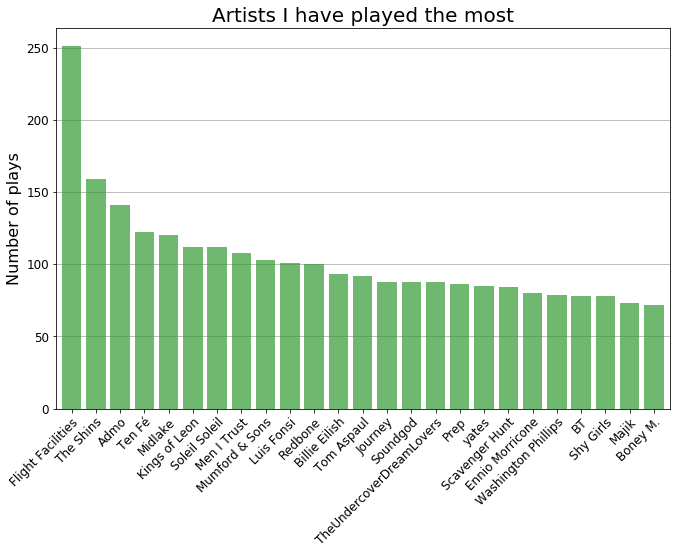

In [5]:
ax = artists_most.plot(kind='bar', figsize=[11, 7], width=0.8, alpha=0.7, color='#339933', edgecolor=None, zorder=2)

ax.yaxis.grid(True)
ax.set_xticklabels(artists_most.index, rotation=45, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_title('Artists I have played the most', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Number of plays', fontproperties=label_font)

# plt.savefig('images/lastfm-artists-played-most.png', dpi=96, bbox_inches='tight')
plt.show()

## Top tracks

In [6]:
tracks_most = pd.read_csv('data/lastfm_top_tracks.csv', encoding='utf-8')

def make_label(row, maxlength=30, suffix='...'):
    artist = row['artist']
    track = row['track']
    if len(track) > maxlength:
        track = '{}{}'.format(track[:maxlength-len(suffix)], suffix)
    return '{}\n{}'.format(artist, track)

index = tracks_most.apply(make_label, axis='columns')
tracks_most = tracks_most.set_index(index).drop(labels=['artist', 'track'], axis='columns')
tracks_most = tracks_most['play_count'].head(20)
tracks_most.head()

Admo\nSparks                                     141
Soleil Soleil\nI'm At The Bottom Of The Ocean    112
Men I Trust\nLauren                              106
Redbone\nCome and Get Your Love                  100
Luis Fonsi\nDespacito ft  Daddy Yankee           100
Name: play_count, dtype: int64

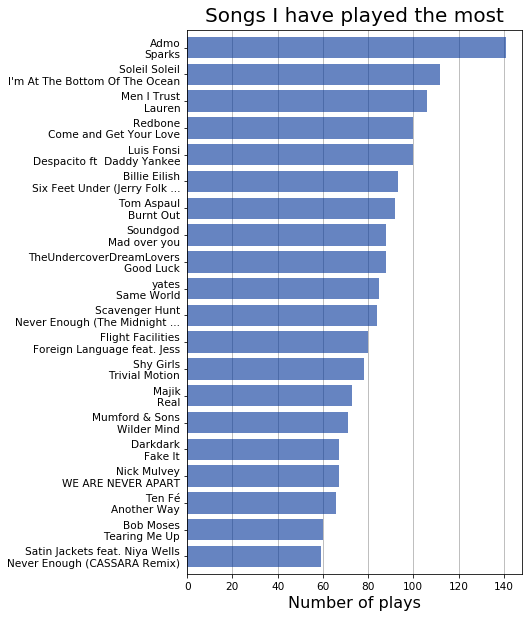

In [7]:
ax = tracks_most.sort_values().plot(kind='barh', figsize=[6, 10], width=0.8, alpha=0.6, 
                                    color='#003399', edgecolor=None, zorder=2)
ax.xaxis.grid(True)
for label in ax.get_xticklabels():
    label.set_fontproperties(ticks_font_h)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font_h)
ax.set_xlabel('Number of plays', fontproperties=label_font)
ax.set_ylabel('', fontproperties=label_font)
ax.set_title('Songs I have played the most', fontproperties=title_font, y=1.005)

# plt.savefig('images/lastfm-tracks-played-most-h.png', dpi=96, bbox_inches='tight')
plt.show()

## Top albums

In [8]:
albums_most = pd.read_csv('data/lastfm_top_albums.csv', encoding='utf-8')

def make_label(row, maxlength=25, suffix='...'):
    artist = row['artist']
    track = row['album']
    if len(track) > maxlength:
        track = '{}{}'.format(track[:maxlength-len(suffix)], suffix)
    return '{}\n{}'.format(artist, track)

index = albums_most.apply(make_label, axis='columns')
albums_most = albums_most.set_index(index).drop(labels=['artist', 'album'], axis='columns')
albums_most = albums_most['play_count'].head(30)
albums_most.head()

Generationals\nBIRP! September 2014     217
Gems\nBIRP! July 2014                   161
Her\nBIRP! November 2015                108
Burning Hotels\nBIRP! September 2011    108
Journey\nGreatest Hits                   88
Name: play_count, dtype: int64

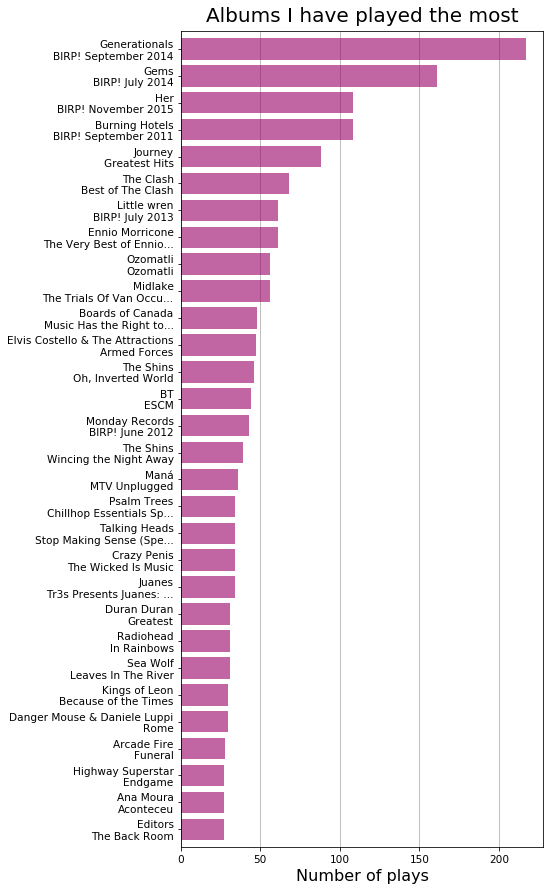

In [9]:
ax = albums_most.sort_values().plot(kind='barh', figsize=[6.5, 15], width=0.8, alpha=0.6, color='#990066', 
                                    edgecolor=None, zorder=2)
ax.xaxis.grid(True)
for label in ax.get_xticklabels():
    label.set_fontproperties(ticks_font_h)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font_h)
ax.set_xlabel('Number of plays', fontproperties=label_font)
ax.set_ylabel('', fontproperties=label_font)
ax.set_title('Albums I have played the most', fontproperties=title_font, y=1.005)

# plt.savefig('images/lastfm-albums-played-most-h.png', dpi=96, bbox_inches='tight')
plt.show()

## All-time scrobbles

In [10]:
# read the all-time scrobbles data set
scrobbles = pd.read_csv('data/lastfm_scrobbles.csv', encoding='utf-8')
scrobbles = scrobbles.drop('timestamp', axis=1)
print('{:,} total scrobbles'.format(len(scrobbles)))
print('{:,} total artists'.format(len(scrobbles['artist'].unique())))

10,684 total scrobbles
2,026 total artists


According to the last.fm web site, I have ~300,000 scrobbles. This API endpoint seems to miss the ones from before 2007.

In [11]:
# convert to datetime
scrobbles['timestamp'] = pd.to_datetime(scrobbles['datetime'])

In [12]:
# functions to convert UTC to Shanghai time zone and extract date/time elements
convert_tz = lambda x: x.to_pydatetime().replace(tzinfo=pytz.utc).astimezone(pytz.timezone('Asia/Shanghai'))
get_year = lambda x: convert_tz(x).year
get_month = lambda x: '{}-{:02}'.format(convert_tz(x).year, convert_tz(x).month) #inefficient
get_day = lambda x: convert_tz(x).day
get_hour = lambda x: convert_tz(x).hour
get_day_of_week = lambda x: convert_tz(x).weekday()

These lambda functions are inefficient, but necessary to workaround this bug: https://github.com/pydata/pandas/issues/11757. I can update them when the bug is fixed in a future pandas version.

In [13]:
# parse out date and time elements as Shanghai time
scrobbles['year'] = scrobbles['timestamp'].map(get_year)
scrobbles['month'] = scrobbles['timestamp'].map(get_month)
scrobbles['day'] = scrobbles['timestamp'].map(get_day)
scrobbles['hour'] = scrobbles['timestamp'].map(get_hour)
scrobbles['dow'] = scrobbles['timestamp'].map(get_day_of_week)
scrobbles = scrobbles.drop(labels=['datetime'], axis=1)

# drop rows with 01-01-1970 as timestamp
scrobbles = scrobbles[scrobbles['year'] > 1970]
scrobbles.head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
0,Daniel Deluxe,20e17bb3-4b34-48d3-bc35-d8e6638e3b4d,"Desync (Original Soundtrack, Vol. 1)",NaN,Breakout,NaN,2018-05-23 07:28:33,2018,2018-05,23,15,2
1,Occams Laser,NaN,Take Your Time,NaN,Just Give Me Your Love,NaN,2018-05-23 07:24:56,2018,2018-05,23,15,2
2,Droid Bishop,NaN,End of Aquarius,NaN,Sagan's Quest,NaN,2018-05-23 07:20:09,2018,2018-05,23,15,2
3,Arcade High,3fe8b0f1-e0b1-406e-a152-2cd6d5ec5145,Kingdom,NaN,Badlands,NaN,2018-05-23 07:16:05,2018,2018-05,23,15,2
4,Kalax,NaN,Kalax,NaN,Soaring,NaN,2018-05-23 07:11:14,2018,2018-05,23,15,2


All the last.fm timestamps of my scrobbles appear to be UTC, but the year, month, day, hour columns are now converted to Pacific Time (where I've done nearly all my listening)

## Year-by-year analysis

Visualize the number of scrobbles per year

In [14]:
year_counts = scrobbles['year'].value_counts().sort_index()

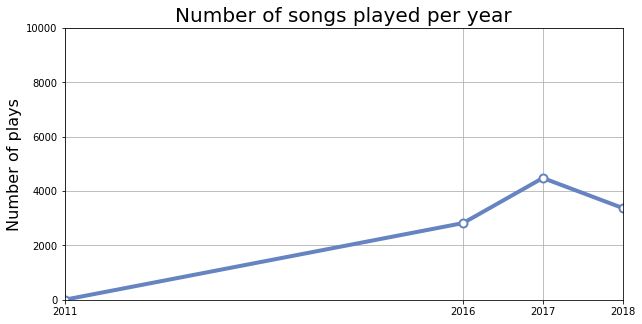

In [15]:
year_counts = scrobbles['year'].value_counts().sort_index()
ax = year_counts.plot(kind='line', figsize=[10, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

ax.set_xlim((year_counts.index[0], year_counts.index[-1]))

ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylim(0, 10000)
ax.set_xticks(year_counts.index)
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played per year', fontproperties=title_font)

# plt.savefig('images/lastfm-scrobbles-per-year.png', dpi=96, bbox_inches='tight')
plt.show()

## Month-by-month analysis

Visualize the number of scrobbles per month from 2010 through the present day

In [16]:
# get all the scrobbles from 2010-present
min_year = 2016
scrobbles_10 = scrobbles[scrobbles['year'] >= min_year]
max_year = max(scrobbles_10['year'])

In [17]:
# count number of scrobbles in each month
month_counts = scrobbles_10['month'].value_counts().sort_index()

# not every month necessarily has a scrobble, so fill in missing months with zero counts
date_range = pd.date_range(start=min(scrobbles_10['timestamp']), end=max(scrobbles_10['timestamp']), freq='D')
months_range = date_range.map(lambda x: str(x.date())[:-3])
index = np.unique(months_range)
month_counts = month_counts.reindex(index, fill_value=0)

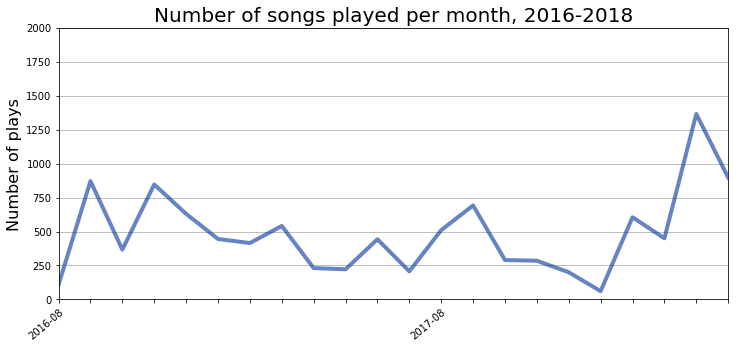

In [18]:
ax = month_counts.plot(kind='line', figsize=[12, 5], linewidth=4, alpha=0.6, color='#003399')

xlabels = month_counts.iloc[range(0, len(month_counts), 12)].index
xlabels = [x if x in xlabels else '' for x in month_counts.index]
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=40, rotation_mode='anchor', ha='right')

ax.set_xlim((0, len(month_counts)-1))

ax.yaxis.grid(True)
ax.set_ylim((0,2000))
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played per month, {}-{}'.format(min_year, max_year), fontproperties=title_font)

# plt.savefig('images/lastfm-scrobbles-per-month.png', dpi=96, bbox_inches='tight')
plt.show()

## Day of the week analysis

How many songs have been played on each day of the week?

In [19]:
# get the play count sum by day of the week
dow_counts = scrobbles['dow'].value_counts().sort_index()
dow_counts.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

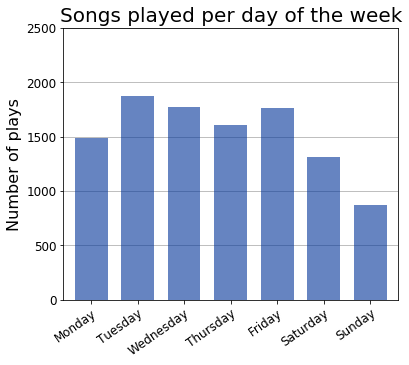

In [20]:
ax = dow_counts.plot(kind='bar', figsize=[6, 5], width=0.7, alpha=0.6, color='#003399', edgecolor=None, zorder=2)

ax.yaxis.grid(True)
ax.set_xticklabels(dow_counts.index, rotation=35, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_ylim((0, 2500))
ax.set_title('Songs played per day of the week', fontproperties=title_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_ylabel('Number of plays', fontproperties=label_font)

# plt.savefig('images/lastfm-scrobbles-per-weekday.png', dpi=96, bbox_inches='tight')
plt.show()

## Hour of the day analysis

How many songs have been played during each hour of the day?

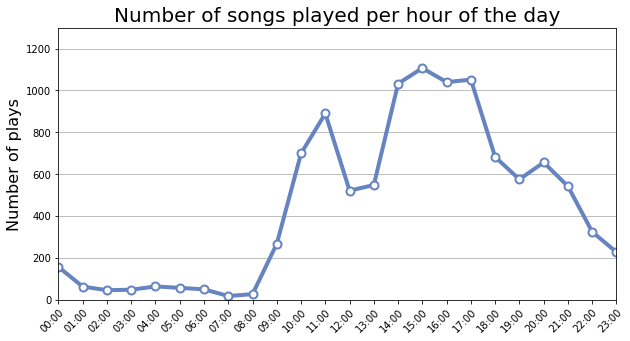

In [21]:
hour_counts = scrobbles['hour'].value_counts().sort_index()
ax = hour_counts.plot(kind='line', figsize=[10, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

xlabels = hour_counts.index.map(lambda x: '{:02}:00'.format(x))
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')

ax.set_xlim((hour_counts.index[0], hour_counts.index[-1]))

ax.yaxis.grid(True)
ax.set_ylim((0, 1300))
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played per hour of the day', fontproperties=title_font)

# plt.savefig('images/lastfm-scrobbles-per-hour.png', dpi=96, bbox_inches='tight')
plt.show()

## Analysis by day of the week + hour of the day

How many songs have been played during each hour of the day on each day of the week?

In [22]:
# get the play counts by hour of day and day of week
weekday_hour_counts = scrobbles.groupby(['dow','hour']).count()['track']
hour_numbers = weekday_hour_counts.index.levels[1]
day_numbers = weekday_hour_counts.index.levels[0]
day_names = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}

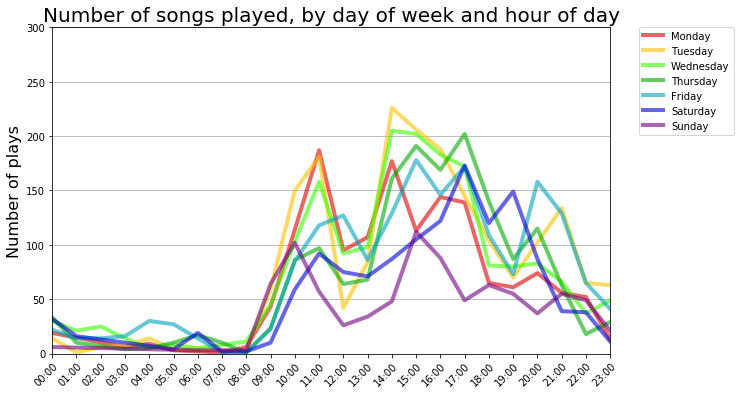

In [23]:
# get one color per day of week
colors = get_colors('nipy_spectral_r', n=len(day_numbers), start=0.1, stop=0.95)

fig, ax = plt.subplots(figsize=[10, 6])
lines = []
for day, c in zip(day_numbers, colors):
    ax = weekday_hour_counts[day].plot(kind='line', linewidth=4, alpha=0.6, c=c)
    lines.append(day_names[day])
    
xlabels = hour_numbers.map(lambda x: '{:02}:00'.format(x))
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')

ax.set_xlim((hour_numbers[0], hour_numbers[-1]))

ax.yaxis.grid(True)
ax.set_ylim([0, 300])
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played, by day of week and hour of day', fontproperties=title_font)
ax.legend(lines, loc='upper right', bbox_to_anchor=(1.23,1.017))

# plt.savefig('images/lastfm-scrobbles-days-hours.png', dpi=96, bbox_inches='tight')
plt.show()

## Analysis of a single year (or multiple years)

Add additional years to the 'isin' list to query multiple years.

In [24]:
scrobbles_year = scrobbles[scrobbles['year'].isin([2018])]
len(scrobbles_year)

3378

In [25]:
# what artists did i play the most that year?
artists_year = scrobbles_year['artist'].value_counts()
artists_year = pd.DataFrame(artists_year).reset_index().rename(columns={'artist':'play count', 'index':'artist'})
artists_year.index = [n + 1 for n in artists_year.index]
artists_year.head(10)

,artist,play count
1,Midlake,115
2,Kings of Leon,75
3,Mitch Murder,65
4,Highway Superstar,42
5,Lindstrøm,34
6,Thievery Corporation,32
7,Boards of Canada,32
8,Com Truise,26
9,The Midnight,25
10,Journey,24


In [26]:
# what tracks did i play the most that year?
tracks_year = scrobbles_year.groupby(['artist', 'track']).count().sort_values('timestamp', ascending=False)
tracks_year = tracks_year.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'track', 'play count']]
tracks_year.index = [n + 1 for n in tracks_year.index]
tracks_year.head(10)

,artist,track,play count
1,Midlake,Roscoe,22
2,The Smiths,Panic,20
3,Neon Nox,Checkpoint - Original Mix,19
4,Mitch Murder,Sniper Rouge,19
5,Sebastian Gampl,One On One (feat. Tommy Reeve),17
6,Daft Punk,Instant Crush (feat. Julian Casablancas),16
7,Mitch Murder,モンタージュ,12
8,VHS DREAMS,Miami's Finest,9
9,The Midnight,Days of Thunder,9
10,Einar Erlander,Catwalk,8


In [27]:
# what albums did i play the most that year?
albums_year = scrobbles_year.groupby(['artist', 'album']).count().sort_values('timestamp', ascending=False)
albums_year = albums_year.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'album', 'play count']]
albums_year.index = [n + 1 for n in albums_year.index]

# remove text in parentheses or brackets
regex = re.compile('\\(.*\\)|\\[.*]')
albums_year['album'] = albums_year['album'].map(lambda x: regex.sub('', x))
albums_year.head(10)

,artist,album,play count
1,Midlake,The Trials Of Van Occupanther,56
2,Boards of Canada,Music Has the Right to Children,31
3,Highway Superstar,Endgame,27
4,Journey,Greatest Hits,24
5,Neon Nox,Unfinished Business,20
6,Mitch Murder,Selection 4,20
7,Alexandros,data,19
8,Midlake,Trials of Van Occupanther,18
9,Kupla,Taiga Native,17
10,Thievery Corporation,The Richest Man in Babylon,17


## Analysis of a single month (or multiple months)

Add additional months to the 'isin' list to query multiple months.

In [28]:
scrobbles_month = scrobbles[scrobbles['month'].isin(['2018-05'])]
len(scrobbles_month)

897

In [29]:
# what artists did i play the most that month?
artists_month = scrobbles_month['artist'].value_counts()
artists_month = pd.DataFrame(artists_month).reset_index().rename(columns={'artist':'play count', 'index':'artist'})
artists_month.index = [n + 1 for n in artists_month.index]
artists_month.head(10)

,artist,play count
1,Highway Superstar,35
2,Alexandros,19
3,Intelligence Dept.,14
4,The Midnight,13
5,Philanthrope,12
6,Kupla,12
7,B-Side,11
8,Juan Rios,11
9,L'indécis,10
10,Defilm,10


In [30]:
# what tracks did i play the most that month?
tracks_month = scrobbles_month.groupby(['artist', 'track']).count().sort_values('timestamp', ascending=False)
tracks_month = tracks_month.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'track', 'play count']]
tracks_month.index = [n + 1 for n in tracks_month.index]
tracks_month.head(10)

,artist,track,play count
1,The Midnight,Days of Thunder,9
2,Highway Superstar,Hunters (feat. Sunglasses Kid & Honey Colonna),8
3,Crystal Bats,Anyone,6
4,VHS DREAMS,Miami's Finest,6
5,Einar Erlander,Catwalk,5
6,Lindstrøm,Didn't Know Better (Original Version),5
7,TESK,DatSwing,4
8,Sebastian Gampl,One On One (feat. Tommy Reeve),4
9,Highway Superstar,Hunters,4
10,Highway Superstar,Dream Diary (feat. Honey Colonna),4


In [31]:
# what albums did i play the most that month?
albums_month = scrobbles_month.groupby(['artist', 'album']).count().sort_values('timestamp', ascending=False)
albums_month = albums_month.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'album', 'play count']]
albums_month.index = [n + 1 for n in albums_month.index]
albums_month.head(10)

,artist,album,play count
1,Highway Superstar,Endgame,26
2,Alexandros,data,19
3,Intelligence Dept.,Sleeping City,14
4,Kupla,Taiga Native,12
5,Defilm,Defilm,10
6,Circulus,The Lick on the Tip of an Envelope Yet to be Sent,9
7,Highway Superstar,Take My Time,9
8,The Midnight,Days of Thunder,9
9,L'indécis,Playtime,8
10,VHS DREAMS,VHS Dreams EP,7


## Listening history of a specific artist, album, or track

See the last 5 times I've listened to someone or something

In [32]:
# when were the last 5 times I played something by Midlake?
scrobbles[scrobbles['artist'].str.contains('Midlake')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
1922,Midlake,da90b5da-349e-4906-a0b4-805f5e46190d,Antiphon,43845284-726a-4a16-8a8a-906c72b225bf,The Old and the Young,d96bad5c-26fd-45be-b594-9937a11a11c3,2018-04-11 10:43:45,2018,2018-04,11,18,2
2747,Midlake,da90b5da-349e-4906-a0b4-805f5e46190d,The Trials Of Van Occupanther (10th Anniversar...,NaN,The Fairest Way,NaN,2018-02-23 04:03:20,2018,2018-02,23,12,4
2896,Midlake,da90b5da-349e-4906-a0b4-805f5e46190d,The Courage Of Others,3a876213-7833-40c1-ac4b-39cb9b767082,Acts Of Man,2d07ebd0-ee68-4e99-b987-f2d092489a62,2018-02-18 11:37:49,2018,2018-02,18,19,6
2897,Midlake,da90b5da-349e-4906-a0b4-805f5e46190d,The Courage of Others (Deluxe),NaN,Fortune,cfd43a5f-5831-4c52-b1b3-12465f7fc1c6,2018-02-18 11:35:43,2018,2018-02,18,19,6
2898,Midlake,da90b5da-349e-4906-a0b4-805f5e46190d,The Courage of Others (Deluxe),NaN,Acts Of Man,2d07ebd0-ee68-4e99-b987-f2d092489a62,2018-02-18 11:31:27,2018,2018-02,18,19,6


In [33]:
# when were the last 5 times I played something off of a Greatest Hits Album?
scrobbles[scrobbles['album'].fillna('').str.contains('Greatest Hits')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
1845,Hall & Oates,debabff3-2559-46e5-862d-ef2a906d7010,"Greatest Hits--Rock 'n' Soul, Part 1",NaN,Kiss On My List,4d8c74f9-4b81-423c-8822-f40ecaa4f940,2018-04-12 10:14:08,2018,2018-04,12,18,3
2019,The Black Crowes,02ceff75-7363-493e-a78d-912dc86c7460,Greatest Hits 1990-1999: A Tribute To A Work I...,NaN,Jealous Again,8478e50a-41db-423e-9393-fd2d26231dab,2018-04-06 15:07:57,2018,2018-04,6,23,4
2680,Journey,abd506e1-6f2b-4d6f-b937-92c267f6f88b,Greatest Hits,03ffc721-3d27-4fb9-a394-c06da971ee5b,I'll Be Alright Without You,22837b47-95b5-4970-8cc3-14b8cf9a963d,2018-03-01 11:27:18,2018,2018-03,1,19,3
2681,Journey,abd506e1-6f2b-4d6f-b937-92c267f6f88b,Greatest Hits,03ffc721-3d27-4fb9-a394-c06da971ee5b,Who's Crying Now,9343700d-506a-41a1-96c6-c88d01b84e28,2018-03-01 11:22:16,2018,2018-03,1,19,3
2682,Journey,abd506e1-6f2b-4d6f-b937-92c267f6f88b,Greatest Hits,03ffc721-3d27-4fb9-a394-c06da971ee5b,Lovin' Touchin' Squeezin',87a25f92-38a1-4e42-8ab5-2ea1391db023,2018-03-01 11:18:25,2018,2018-03,1,19,3


In [34]:
# when were the last 5 times I played Maneater?
scrobbles[scrobbles['track'].str.contains('Maneater')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
1969,Hall & Oates,debabff3-2559-46e5-862d-ef2a906d7010,H2O,c5438ca5-8e7e-30c9-9fb1-f482319883df,Maneater - Remastered,NaN,2018-04-10 04:50:38,2018,2018-04,10,12,1
3521,Hall & Oates,debabff3-2559-46e5-862d-ef2a906d7010,NaN,NaN,Maneater (The Apple Scruffs Mix),NaN,2017-12-08 13:25:32,2017,2017-12,8,21,4
3522,Hall & Oates,debabff3-2559-46e5-862d-ef2a906d7010,NaN,NaN,Maneater (The Apple Scruffs Mix),NaN,2017-12-08 13:18:41,2017,2017-12,8,21,4
3523,Hall & Oates,debabff3-2559-46e5-862d-ef2a906d7010,NaN,NaN,Maneater (The Apple Scruffs Mix),NaN,2017-12-08 13:11:49,2017,2017-12,8,21,4
3524,Hall & Oates,debabff3-2559-46e5-862d-ef2a906d7010,NaN,NaN,Maneater (The Apple Scruffs Mix),NaN,2017-12-08 13:04:58,2017,2017-12,8,21,4


## Visualize top artists over time

How have the cumulative plays of most listened-to artists changed over time?

In [35]:
# get the cumulative play counts since 2009 for the top n most listened-to artists
n = 6
plays = scrobbles[scrobbles['artist'].isin(artists_most.head(n).index)]
plays = plays[plays['year'] >= 2009]
plays = plays.groupby(['artist','year']).count().groupby(level=[0]).cumsum()['track']

# make sure we have each year represented for each artist, even if they got no plays that year
plays = plays.unstack().T.fillna(method='ffill').T.stack()
top_artists = plays.index.levels[0]

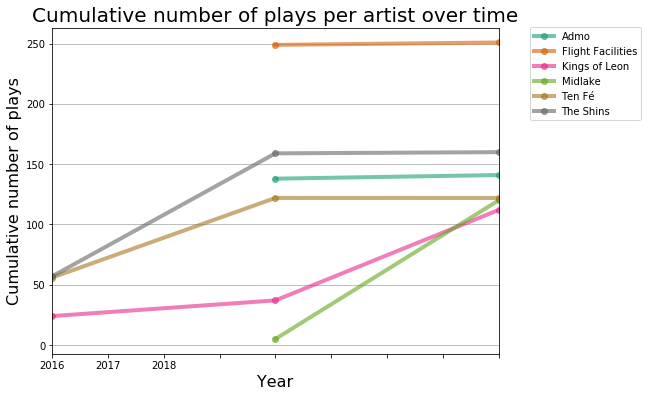

In [36]:
# get one color per artist
colors = get_colors('Dark2', n)

fig, ax = plt.subplots(figsize=[8, 6])
lines = []
for artist, c in zip(top_artists, colors):
    ax = plays[artist].plot(kind='line', linewidth=4, alpha=0.6, marker='o', c=c)
    lines.append(artist)
    
ax.set_xlim((plays.index.get_level_values(1).min(), plays.index.get_level_values(1).max()))

ax.yaxis.grid(True)
ax.set_xticklabels(plays.index.levels[1], rotation=0, rotation_mode='anchor', ha='center')
ax.set_ylabel('Cumulative number of plays', fontproperties=label_font)
ax.set_xlabel('Year', fontproperties=label_font)
ax.set_title('Cumulative number of plays per artist over time', fontproperties=title_font)
ax.legend(lines, loc='upper right', bbox_to_anchor=(1.33, 1.016))

# plt.savefig('images/lastfm-scrobbles-top-artists-years.png', dpi=96, bbox_inches='tight')
plt.show()

## Characteristics of artists' names

Text analysis of artist name strings

In [37]:
# remove 'The ' and 'A ' preceding artist names, get unique set of names, then get first letter frequency
artists_clean = scrobbles['artist'].str.replace('The ','').str.replace('A ','')
first_letters = pd.Series(artists_clean.unique()).map(lambda x: x.upper()[0]).value_counts()
first_letters = first_letters[[c for c in string.ascii_uppercase]]

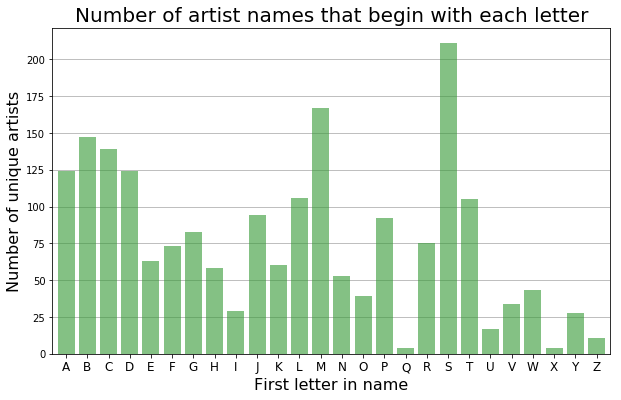

In [38]:
# plot the frequency of artist names that begin with each letter
ax = first_letters.plot(kind='bar', figsize=[10, 6], width=0.8, alpha=0.6, color='#339933', edgecolor=None, zorder=2)
ax.yaxis.grid(True)
ax.set_xticklabels(first_letters.index, rotation=0, rotation_mode='anchor', ha='center', fontproperties=ticks_font)

ax.set_title('Number of artist names that begin with each letter', fontproperties=title_font)
ax.set_xlabel('First letter in name', fontproperties=label_font)
ax.set_ylabel('Number of unique artists', fontproperties=label_font)

# plt.savefig('images/lastfm-artists-first-letter-count.png', dpi=96, bbox_inches='tight')
plt.show()

In [39]:
# which artist names begin with the letter 'X'?
str(list(pd.Series(artists_clean[artists_clean.str.upper().str.startswith('X')].unique())))

"['XXYYXX', 'XTC', 'Xavier Luna', 'xx']"

In [40]:
# what are the most common first words in artist names that begin with 'M'?
artists_m = pd.Series(artists_clean[artists_clean.str.upper().str.startswith('M')].unique())
artists_m.map(lambda x: x.split()[0]).value_counts().head(15)

Midnight    5
My          3
Mr.         3
Matt        3
Mark        3
Magic       3
Mount       2
Modern      2
Mad         2
Martin      2
Michael     2
Monsieur    2
Mirror      2
Mac         2
Maximum     2
dtype: int64

In [41]:
# what are the most common first words in all the artist names?
pd.Series(scrobbles['artist'].unique()).map(lambda x: x.split()[0].lower()).value_counts().head(15)

the         114
a             9
david         8
black         6
tom           6
dj            5
chris         5
neon          5
frank         5
james         5
midnight      4
zaho          4
ghost         4
sam           4
dream         4
dtype: int64

In [42]:
# what are the most common words in all the artist names, anywhere in the name?
word_list = []
stop_list = ['&','the','and','of','a','in','for','la','los','el','de','y']
for artist in artists_clean.unique():
    for word in artist.split():
        word_list.append(word.lower())

word_list = [word for word in word_list if word not in stop_list]
pd.Series(word_list).value_counts().head(15)

black     11
james      9
club       9
david      9
smith      7
band       7
white      7
sounds     6
tom        6
love       6
lights     6
sea        6
music      6
dream      6
ghost      6
dtype: int64

In [43]:
# what is the longest artist name?
print('"{}"'.format(max(artists_clean, key=len)))

"Chef Makes One of Gordon's Dishes and He's Not Happy"


In [44]:
# what is the distribution of lengths of artist names (up to n number of characters)?
n = 50
name_lengths = pd.Series([len(artist) for artist in artists_clean.unique()])
name_lengths = name_lengths.value_counts().sort_index()
name_lengths = name_lengths.iloc[0:n+1].reindex(range(n+1), fill_value=0)

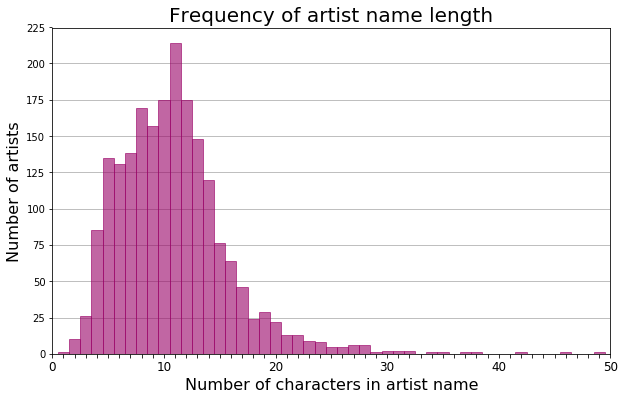

In [45]:
ax = name_lengths.plot(kind='bar', figsize=(10,6), alpha=0.6, width=1, color='#990066', edgecolor='#990066', zorder=2)

xlabels = [x if x % 10 == 0 else '' for x in name_lengths.index]
ax.set_xticklabels(xlabels, rotation=0, rotation_mode='anchor', ha='center', fontproperties=ticks_font)
ax.yaxis.grid(True)
ax.set_xlim((0,n))

ax.set_title('Frequency of artist name length', fontproperties=title_font)
ax.set_xlabel('Number of characters in artist name', fontproperties=label_font)
ax.set_ylabel('Number of artists', fontproperties=label_font)

# plt.savefig('images/lastfm-artists-name-length.png', dpi=96, bbox_inches='tight')
plt.show()

# Checking for Duplicates

In [46]:
len(scrobbles[scrobbles.duplicated() == True])

3

In [47]:
scrobbles[scrobbles.duplicated() == True].head() # single duplicate

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
1200,Sebastian Gampl,NaN,City Hunter,NaN,One On One (feat. Tommy Reeve),NaN,2018-04-25 05:37:45,2018,2018-04,25,13,2
4600,Talking Heads,a94a7155-c79d-4409-9fcf-220cb0e4dc3a,Stop Making Sense (Special Edition),NaN,Life During Wartime,e2209423-291a-46ea-b3e9-935be1a5b41f,2017-09-09 06:55:43,2017,2017-09,9,14,5
9400,The Shins,6c8b9855-ba8b-48f9-ac1d-42167f7f7b18,"Oh, Inverted World",bfaaaca7-2776-3d8c-9f10-f56579d0082d,Weird Divide,7fdf8076-14a1-4f2d-846c-ba9e5e9710f9,2016-10-28 08:02:35,2016,2016-10,28,16,4


In [48]:
# when were the last 5 times I played something by My Bloody Valentine?
scrobbles[scrobbles['artist'].str.contains('Mariza')].head()

,artist,artist_mbid,album,album_mbid,track,track_mbid,timestamp,year,month,day,hour,dow
6517,Mariza,8cbb4d57-f44d-433a-90bf-a0892af886e1,Fado Em Mim,c7791e52-0980-40be-8de7-a770400428ee,Chuva,54035c14-e5ef-48db-9110-ac7e9f37368f,2017-03-27 08:24:46,2017,2017-03,27,16,0
7538,Mariza,8cbb4d57-f44d-433a-90bf-a0892af886e1,Fado Em Mim,c7791e52-0980-40be-8de7-a770400428ee,Oica O Sr. Vinho,NaN,2017-01-10 06:41:38,2017,2017-01,10,14,1
7539,Mariza,8cbb4d57-f44d-433a-90bf-a0892af886e1,Transparente,68d8d045-630b-3ba5-8ab9-0b7929625706,Fado Tordo,ee0e9a2d-4932-40c3-a008-6aeb3f6bbdf4,2017-01-10 06:39:24,2017,2017-01,10,14,1
7543,Mariza,8cbb4d57-f44d-433a-90bf-a0892af886e1,Fado Em Mim,c7791e52-0980-40be-8de7-a770400428ee,Chuva,54035c14-e5ef-48db-9110-ac7e9f37368f,2017-01-10 06:25:54,2017,2017-01,10,14,1
8507,Mariza,8cbb4d57-f44d-433a-90bf-a0892af886e1,Transparente,68d8d045-630b-3ba5-8ab9-0b7929625706,Recusa,aed913f8-1115-44ce-a38e-b0b6ac6624e1,2016-11-25 17:15:21,2016,2016-11,26,1,5


# Monthly Review: Music Listening

In [49]:
targetMonth = '2018-04' # edit month here
scrobbles_month = scrobbles[scrobbles['month'].isin([targetMonth])]
len(scrobbles_month)

1365

In [50]:
# listening during which hours
len(scrobbles_month.hour.unique())

18

In [51]:
# what artists did i play the most that month?
artists_month = scrobbles_month['artist'].value_counts()
artists_month = pd.DataFrame(artists_month).reset_index().rename(columns={'artist':'play count', 'index':'artist'})
artists_month.index = [n + 1 for n in artists_month.index]
artists_month.head(10)

,artist,play count
1,Mitch Murder,57
2,Thievery Corporation,32
3,Lindstrøm,27
4,Com Truise,26
5,Live,21
6,Neon Nox,19
7,Phaserland,19
8,Garth Knight,18
9,Lost Years,16
10,Robert Parker,13


In [52]:
# what tracks did i play the most that month?
tracks_month = scrobbles_month.groupby(['artist', 'track']).count().sort_values('timestamp', ascending=False)
tracks_month = tracks_month.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'track', 'play count']]
tracks_month.index = [n + 1 for n in tracks_month.index]
tracks_month.head(10)

,artist,track,play count
1,Mitch Murder,Sniper Rouge,17
2,Neon Nox,Checkpoint - Original Mix,16
3,Sebastian Gampl,One On One (feat. Tommy Reeve),13
4,Mitch Murder,モンタージュ,11
5,The Midnight,Endless Summer (Instrumental),8
6,Lindstrøm,Boney M Down,8
7,Lindstrøm,The Magnificent - Original Mix,6
8,Live,Rattlesnake,5
9,Bjørn Torske,Hard trafikk,5
10,diskJokke,Flott Flyt,5


In [53]:
# what albums did i play the most that month?
albums_month = scrobbles_month.groupby(['artist', 'album']).count().sort_values('timestamp', ascending=False)
albums_month = albums_month.reset_index().rename(columns={'timestamp':'play count'})[['artist', 'album', 'play count']]
albums_month.index = [n + 1 for n in albums_month.index]
albums_month.head(10)

,artist,album,play count
1,Mitch Murder,Selection 4,18
2,Thievery Corporation,The Richest Man in Babylon,17
3,Neon Nox,Unfinished Business,17
4,Thievery Corporation,Treasures from the Temple,15
5,Sebastian Gampl,City Hunter,13
6,Com Truise,Iteration,13
7,Live,Throwing Copper,12
8,Mitch Murder,Selection 3,12
9,Gunship,Gunship,11
10,Lost Years,Venom,10


In [54]:
# listening days
listeningDays = len(scrobbles_month.day.unique())

In [55]:
# percentage of listening days in month
# total days in month
from datetime import datetime
dt = datetime.strptime(targetMonth, '%Y-%m')
from calendar import monthrange
round((listeningDays / monthrange(dt.year, dt.month)[1]), 3)

1.0

In [56]:
scrobbles_month['hour'].head()

897    22
898    22
899    22
900    22
901    22
Name: hour, dtype: int64

In [57]:
hour_counts = scrobbles_month['hour'].value_counts().sort_index()
hour_counts

0      38
1       5
8      10
9     130
10    137
11    134
12     95
13     78
14     86
15     65
16    104
17     81
18     44
19     57
20    114
21     69
22     69
23     49
Name: hour, dtype: int64

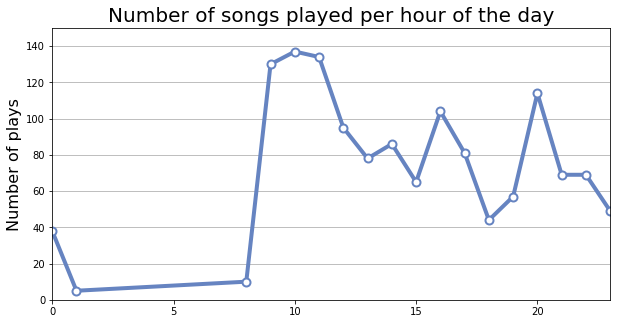

In [58]:
hour_counts = scrobbles_month['hour'].value_counts().sort_index()
ax = hour_counts.plot(kind='line', figsize=[10, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

ax.set_xlim((hour_counts.index[0], hour_counts.index[-1]))

ax.yaxis.grid(True)
ax.set_ylim((0, 150))
ax.set_ylabel('Number of plays', fontproperties=label_font)
ax.set_xlabel('', fontproperties=label_font)
ax.set_title('Number of songs played per hour of the day', fontproperties=title_font)

plt.show()